<a href="https://colab.research.google.com/github/dburchill/ML_nano_poject02/blob/master/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [2]:
!pip install  -q -U tensorflow-datasets
!pip install  -q -U tensorflow-hub

     |████████████████████████████████| 3.4MB 2.8MB/s 


In [3]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.2.0
	• tf.keras version: 2.3.0-tf
	• Running on GPU


## Load the Dataset

load the Oxoxford_flowers102f dataset, create three datasets, one for training, one for validation and one for testing

In [6]:
# (training_set, validation_set, test_set), dataset_info = tfds.load('oxford_flowers102', split=[
#     tfds.core.ReadInstruction('train'),
#     tfds.core.ReadInstruction('test'),
#     tfds.core.ReadInstruction('validation')],
#     as_supervised=True,
#     with_info=True)
    
(training_set, validation_set, test_set), dataset_info = tfds.load('oxford_flowers102', split=['train', 'test', 'validation'], as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete0TCVN0/oxford_flowers102-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete0TCVN0/oxford_flowers102-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete0TCVN0/oxford_flowers102-validation.tfrecord
Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


## Explore the dataset


### print dataset info

In [7]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

### get the number of classes and examples in each split of the dataset


In [8]:
num_classes = dataset_info.features['label'].num_classes
train_size = dataset_info.splits['train'].num_examples 
test_size = dataset_info.splits['train'].num_examples 
val_size = dataset_info.splits['train'].num_examples 
print('The Dataset has a total of:')
print('\u2022 {:,} classes'.format(num_classes))
print('\u2022 {:,} training  set size'.format(train_size))
print('\u2022 {:,} validation set size'.format(val_size))
print('\u2022 {:,} test set size'.format(test_size))
 

The Dataset has a total of:
• 102 classes
• 1,020 training  set size
• 1,020 validation set size
• 1,020 test set size


### Print lable and size of three images from the training split

In [9]:
for image, label in training_set.take(3):
  print('Shape: ', image.shape,'Label: ',label)
  print()


Shape:  (500, 667, 3) Label:  tf.Tensor(72, shape=(), dtype=int64)

Shape:  (500, 666, 3) Label:  tf.Tensor(84, shape=(), dtype=int64)

Shape:  (670, 500, 3) Label:  tf.Tensor(70, shape=(), dtype=int64)



### Print one images from the dataset
With label, class name, and image shape

In [11]:
import json

# to access json file on google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

with open('/gdrive/My Drive/label_map.json', 'r') as f:
    class_names = json.load(f)

print(class_names)
print(class_names['1'])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monk

In [ ]:
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()
    
    # dataset labes are 0 based, class_name is 1 based, need to add 1 to dataset label
    print('Label: ', class_names[str(label + 1)], '(', label, ')', '  size: ', image.shape)
    plt.imshow(image)
    plt.show()


# Create the pipeline


In [12]:
image_size = 224
batch_size = 64


def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = training_set.cache().shuffle(train_size//4).map(normalize).batch(batch_size).prefetch(1)
testing_batches = test_set.cache().map(normalize).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().map(normalize).batch(batch_size).prefetch(1)

# Build the network


In [59]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

feature_extractor.trainable = False
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dense(num_classes, activation= 'softmax')
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_7 (Dense)              (None, 102)               26214     
Total params: 2,612,134
Trainable params: 354,150
Non-trainable params: 2,257,984
_________________________________________________________________


# Train

In [60]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: True


In [81]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Stop training when there is no improvement in the validation loss for 10 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('/gdrive/My Drive/best_model.h5',
                                               monitor='val_loss',
                                               save_best_only=True)

EPOCHS = 10
history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data=validation_batches)
                    #callbacks=[early_stopping, save_best])

# EPOCHS = 20
# # Stop training when there is no improvement in the validation loss for 5 consecutive epochs
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# history = model.fit(training_batches,
#                     epochs=EPOCHS,
#                     validation_data=validation_batches,
#                     callbacks=[early_stopping])

Epoch 1/10
16/16 [==============================] - 19s 1s/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.0375 - val_accuracy: 0.7429
Epoch 2/10
16/16 [==============================] - 19s 1s/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.0317 - val_accuracy: 0.7585
Epoch 3/10
16/16 [==============================] - 19s 1s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.9275 - val_accuracy: 0.7691
Epoch 4/10
16/16 [==============================] - 19s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.9741 - val_accuracy: 0.7715
Epoch 5/10
16/16 [==============================] - 19s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.8959 - val_accuracy: 0.7850
Epoch 6/10
16/16 [==============================] - 19s 1s/step - loss: 7.9178e-04 - accuracy: 1.0000 - val_loss: 0.8934 - val_accuracy: 0.7853
Epoch 7/10
16/16 [==============================] - 19s 1s/step - loss: 6.3726e-04 - accuracy: 1.0000 - val_loss: 0.8924 - val_accuracy: 0.7844
Epoch 8/10
1

In [82]:


reloaded_keras_model_from_SavedModel = tf.keras.models.load_model("/gdrive/My Drive/best_model.h5", custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_keras_model_from_SavedModel.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_7 (Dense)              (None, 102)               26214     
Total params: 2,612,134
Trainable params: 354,150
Non-trainable params: 2,257,984
_________________________________________________________________


In [56]:
print('history.history has type:', type(history.history))
print('\nThe keys of history.history are:', list(history.history.keys()))
print(history.history['loss'])
print(len(history.history['accuracy']))
print(len(history.history['val_accuracy']))
print(len(history.history['loss']))
print(len(history.history['val_loss']))

history.history has type: <class 'dict'>

The keys of history.history are: ['loss', 'accuracy', 'val_loss', 'val_accuracy']
[0.01690160669386387, 0.020847199484705925, 0.00770169822499156, 0.0029516166541725397, 0.0013403843622654676, 0.0008939521503634751, 0.000748480495531112, 0.0006703864200972021, 0.0006097342120483518, 0.000556760816834867, 0.0005164561443962157, 0.00047706434270367026, 0.0004421464691404253, 0.0004103454702999443, 0.0003813766816165298, 0.00035720859887078404, 0.00033400848042219877, 0.00031456828583031893, 0.0002947942411992699, 0.0002777407644316554]
20
20
20
20


In [83]:
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

loss, accuracy = reloaded_keras_model_from_SavedModel.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

16/16 [==============================] - 2s 156ms/step - loss: 0.7097 - accuracy: 0.8216

Loss on the TEST Set: 0.710
Accuracy on the TEST Set: 82.157%
16/16 [==============================] - 3s 157ms/step - loss: 0.7146 - accuracy: 0.8147

Loss on the TEST Set: 0.715
Accuracy on the TEST Set: 81.471%


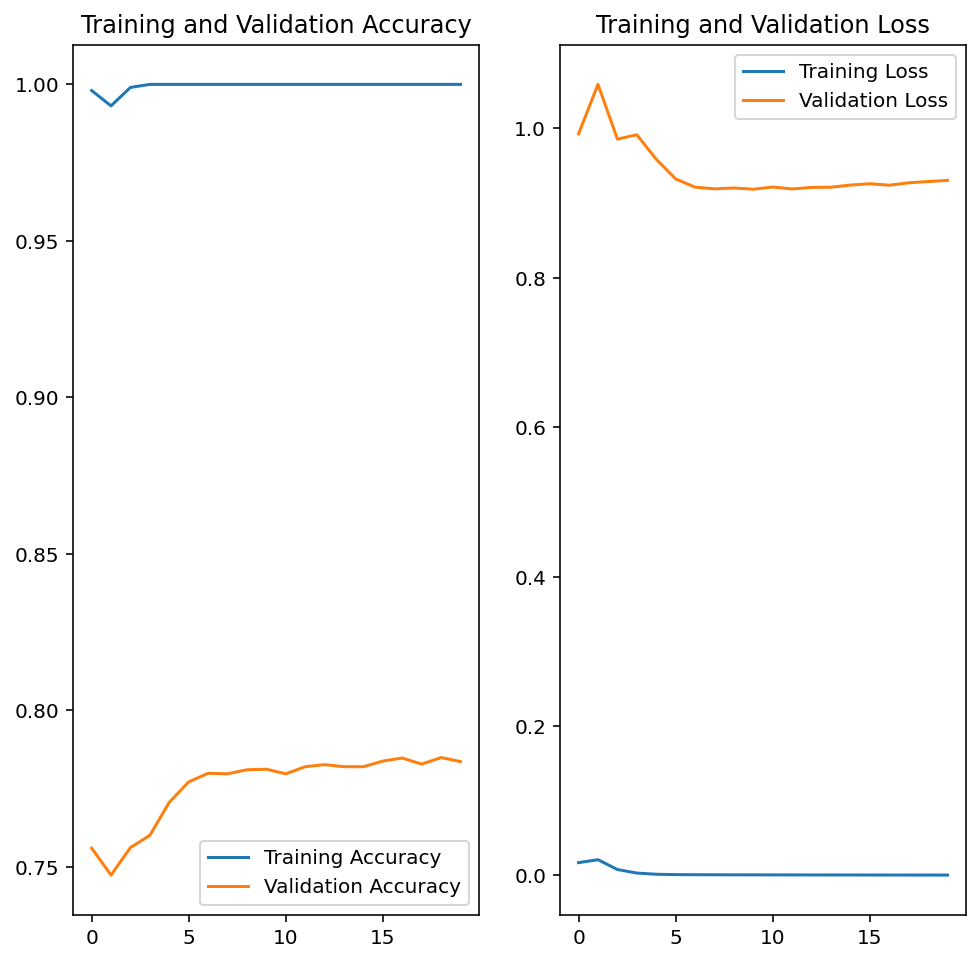

In [58]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# overfitting 
It is startging to show signs of overfitting after just two epochs, retrain with only 2 epochs. 

In [49]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 2
# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/2
16/16 [==============================] - 19s 1s/step - loss: 0.0183 - accuracy: 0.9990 - val_loss: 1.1192 - val_accuracy: 0.7351
Epoch 2/2
16/16 [==============================] - 19s 1s/step - loss: 0.0135 - accuracy: 0.9990 - val_loss: 1.0339 - val_accuracy: 0.7409


In [48]:
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

16/16 [==============================] - 3s 165ms/step - loss: 0.8125 - accuracy: 0.7902

Loss on the TEST Set: 0.813
Accuracy on the TEST Set: 79.020%


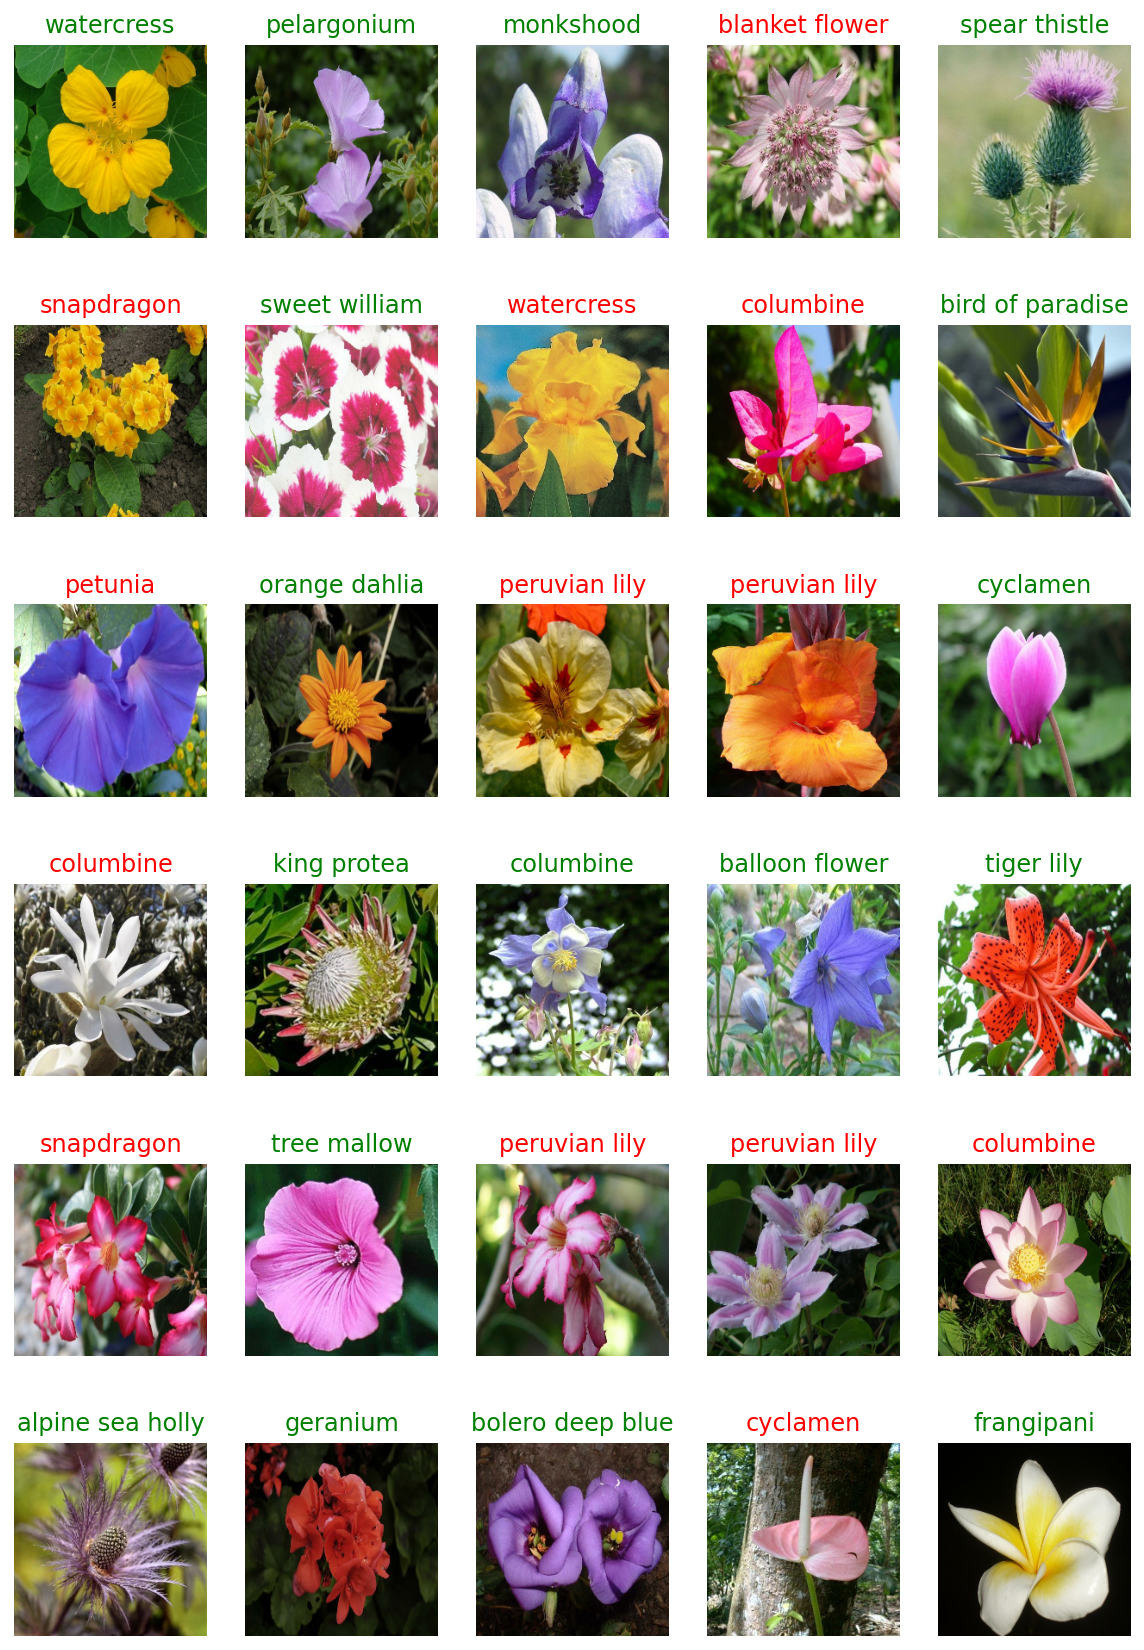

In [54]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[str(np.argmax(ps[n])+1)], color=color)
    plt.axis('off')